* Preliminary explore of the data from https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data
* images are not geotiffs so use skimage - rasterio/gdla is not available on kaggle
* 450 1km x 1km satellite images in both 3-band and 16-band formats

Imagery details
* Sensor : WorldView 3
* Wavebands :
* Panchromatic: 450-800 nm
* 8 Multispectral: (red, red edge, coastal, blue, green, yellow, near-IR1 and near-IR2) 400 nm - 1040 nm
* 8 SWIR: 1195 nm - 2365 nm
* Sensor Resolution (GSD) at Nadir :
* Panchromatic: 0.31m 
* Multispectral: 1.24 m
* SWIR: Delivered at 7.5m

Dynamic Range
* Panchromatic and multispectral : 11-bits per pixel
* SWIR : 14-bits per pixel

In [1]:
import os
import glob
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline

fig_width, fig_height = 14, 14

In [2]:
data_dir = '/Users/robincole/Documents/kaggle/dstl/'

In [3]:
glob.glob(data_dir + '*')

['/Users/robincole/Documents/kaggle/dstl/grid_sizes.csv',
 '/Users/robincole/Documents/kaggle/dstl/train_wkt_v4.csv',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3',
 '/Users/robincole/Documents/kaggle/dstl/sample_submission.csv',
 '/Users/robincole/Documents/kaggle/dstl/three_band']

## Images in RGB
RGB in `three_band`

In [4]:
three_band = glob.glob(data_dir + 'three_band/*', recursive=True)
print(len(three_band))
three_band[:3]

450


['/Users/robincole/Documents/kaggle/dstl/three_band/6180_4_3.tif',
 '/Users/robincole/Documents/kaggle/dstl/three_band/6130_0_4.tif',
 '/Users/robincole/Documents/kaggle/dstl/three_band/6120_0_4.tif']

There are 450 three band images, lets show one

In [5]:
image_file = three_band[0]

(3345, 3395, 3)


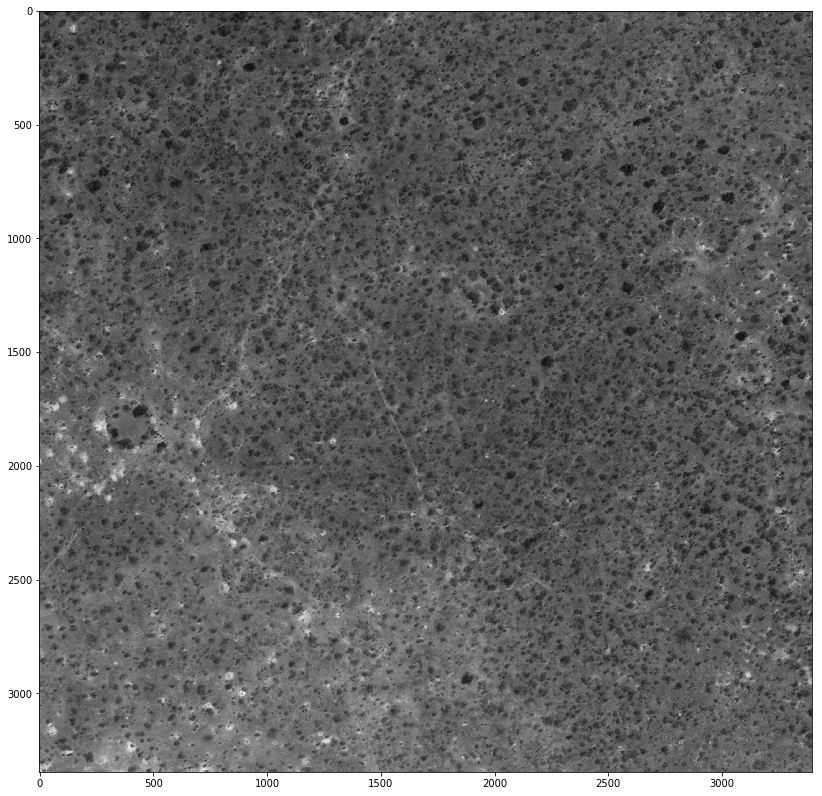

In [6]:
im = io.imread(image_file)
print(im.shape)
f, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
ax.imshow(im[:,:,0], cmap='gist_gray');

## 16 Band images
The full dataset is in `sixteen_band/` and I expect these will be much more useful than just RGB

The 16 bands are distributed in the images with `file name = {ImageId}_{A/M/P}.tif`

In [7]:
sixteen_band = glob.glob(data_dir + 'sixteen_band/*', recursive=True)
print(len(sixteen_band))
sixteen_band[:6]

1350


['/Users/robincole/Documents/kaggle/dstl/sixteen_band/6080_0_3_P.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6020_4_4_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6020_0_0_A.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6120_0_3_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6010_3_3_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6180_4_4_P.tif']

We have images with `P, M, A` suffixes corresponding to A band (8 channels) + M band (8 channels) + P band (1 channel)

Lets plot a PAN image

In [8]:
def get_image_id(file_path):
    """
    Return the image_id from an image file_path
    """
    return file_path.split('.')[0].split('/')[-1][:-2]

In [9]:
image_file = sixteen_band[0]
image_file

'/Users/robincole/Documents/kaggle/dstl/sixteen_band/6080_0_3_P.tif'

image_id : 6080_0_3
(3350, 3339)


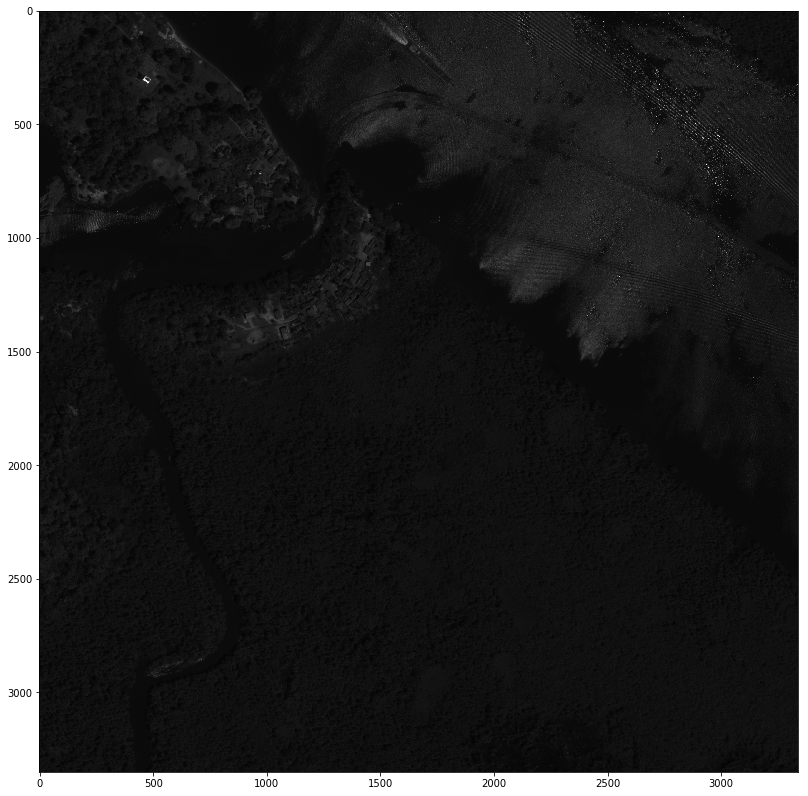

In [10]:
im = io.imread(image_file)
print(f"image_id : {get_image_id(image_file)}")
print(im.shape)
f, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
ax.imshow(im, cmap='gist_gray');

## Explore tabular data

### Grid sizes
First `grid_sizes` - the sizes of grids for all the images
* ImageId - ID of the image
* Xmax - maximum X coordinate for the image
* Ymin - minimum Y coordinate for the image

In [11]:
grid_sizes = pd.read_csv(data_dir + 'grid_sizes.csv')

In [12]:
grid_sizes.shape

(450, 3)

In [13]:
grid_sizes.head()

,Unnamed: 0,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904


### Training labels
`train_wkt.csv` - the WKT format of all the training labels
* ImageId - ID of the image
* ClassType - type of objects (1-10)
* MultipolygonWKT - the labeled area, which is multipolygon geometry represented in WKT format 

1 Buildings - large building, residential, non-residential, fuel storage facility, fortified building

2 Misc. Manmade structures 

3 Road 

4 Track - poor/dirt/cart track, footpath/trail

5 Trees - woodland, hedgerows, groups of trees, standalone trees

6 Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops

7 Waterway 

8 Standing water

9 Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle

10 Vehicle Small - small vehicle (car, van), motorbike

In [14]:
train_wkt = pd.read_csv(data_dir + 'train_wkt_v4.csv')

In [15]:
train_wkt.shape

(250, 3)

In [16]:
train_wkt.head(20)

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...
5,6040_2_2,6,MULTIPOLYGON EMPTY
6,6040_2_2,7,MULTIPOLYGON EMPTY
7,6040_2_2,8,MULTIPOLYGON EMPTY
8,6040_2_2,9,MULTIPOLYGON EMPTY
9,6040_2_2,10,MULTIPOLYGON EMPTY


In [17]:
print(len(train_wkt['ImageId'].unique()))
train_wkt['ImageId'].unique()

25


array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'],
      dtype=object)

Hmm there are only 25 training images..

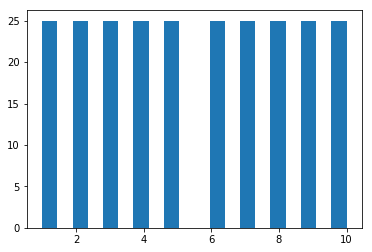

In [18]:
plt.hist(train_wkt['ClassType'], bins=20);

Appears we have uniform distribution of classes

### Sample submission

`sample_submission.csv` - a sample submission file in the correct format
* ImageId - ID of the image
* ClassType - type of objects (1-10)
* MultipolygonWKT - the labeled area, which is multipolygon geometry represented in WKT format

In [19]:
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

In [20]:
sample_submission.head()

,ImageId,ClassType,MultipolygonWKT
0,6120_2_4,1,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
1,6120_2_4,2,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
2,6120_2_4,3,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
3,6120_2_4,4,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4,6120_2_4,5,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
